In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import random
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.utils import to_categorical, normalize
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
import time
from tensorflow.keras.models import model_from_json
from tensorflow.keras.optimizers import SGD


/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [2]:
DATADIR = os.path.join(os.getcwd(),"repair1","train")
TESTDIR = os.path.join(os.getcwd(),"repair1","test")
CATEGORIES = ["defect","normal"]
IMG_SIZE = 112
X,X_test,y,y_test = [],[],[],[]

TIME = int(time.time())
NAME = 'defect-model-{}'.format(TIME)
tensorboard = TensorBoard(log_dir = 'logs/{}'.format(NAME))

In [3]:
def load_data(X,X_test,y,y_test):
    for category in CATEGORIES:
        class_num = CATEGORIES.index(category)
        path = os.path.join(DATADIR,category)
        test_path = os.path.join(TESTDIR,category)
        
        sorted_list = os.listdir(path)
        sorted_list.sort()
        for img in sorted_list:
            if img.endswith(".jpg"):
                img_array =cv2.imread(os.path.join(path,img),0)
                new_array = cv2.resize(img_array, (IMG_SIZE,IMG_SIZE))
                X.append(new_array)
                y.append(class_num)
                
                
        sorted_list = os.listdir(test_path)
        sorted_list.sort()
        
        for img in sorted_list:
            if img.endswith(".jpg"):
                img_array =cv2.imread(os.path.join(test_path,img),0)
                new_array = cv2.resize(img_array, (IMG_SIZE,IMG_SIZE))

                X_test.append(new_array)
                y_test.append(class_num)

    H = np.array(X[::2]).reshape(-1,IMG_SIZE,IMG_SIZE)
    V = np.array(X[1::2]).reshape(-1,IMG_SIZE,IMG_SIZE)
    HV = H-V
    X = np.stack((H,V, HV), axis=3)
    
    y = np.array(y[::2])
    y_test = np.array(y_test[::2])

    H = np.array(X_test[::2]).reshape(-1,IMG_SIZE,IMG_SIZE)
    V = np.array(X_test[1::2]).reshape(-1,IMG_SIZE,IMG_SIZE)
    HV = H - V
    X_test = np.stack((H,V,HV), axis=3)
        
    print(X.shape)
    print(len(y))
    print(X_test.shape)
    print(len(y_test))
    return (X,X_test,y,y_test)
(X,X_test,y,y_test) = load_data(X,X_test,y,y_test)


(4428, 112, 112, 3)
4428
(4816, 112, 112, 3)
4816


In [4]:
print(y_test[:42])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1]


In [5]:
print(len(X))
X = normalize(X)
print(X.shape)
X_test = normalize(X_test)

y = np.array(y)
y_test = np.array(y_test)

#randomize = np.arange(len(X))
#np.random.shuffle(randomize)
#X = X[randomize]
#y = y[randomize]

4428
(4428, 112, 112, 3)


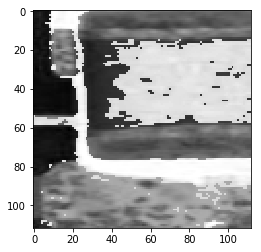

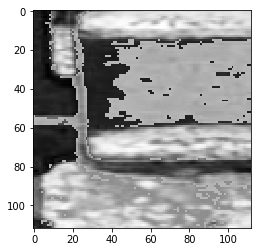

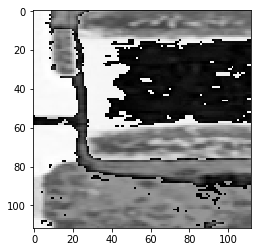

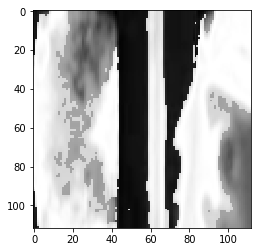

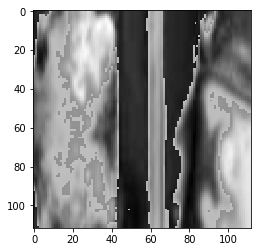

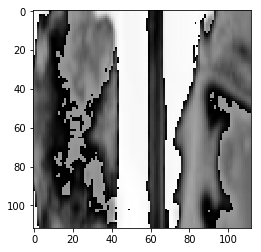

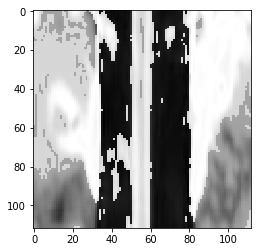

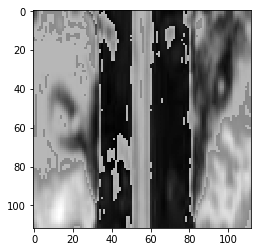

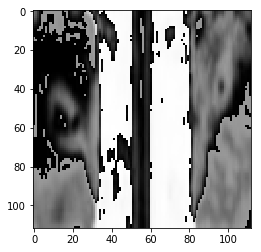

In [6]:
for i in range(3):
    b,g,r = cv2.split(X_test[i])
    plt.imshow(b, cmap = 'gray')
    plt.show()
    
    plt.imshow(g, cmap = 'gray')
    plt.show()
    
    plt.imshow(r, cmap = 'gray')
    plt.show()

In [7]:
def inception_v2():
    def inception_block(foo, filters = 1):
        layer_1 = Conv2D(int(96 * filters), (1,1), padding='same', activation='relu')(foo)
        layer_1 = Conv2D(int(64 * filters), (3,3), padding='same', activation='relu')(layer_1)

        layer_2 = Conv2D(int(16 * filters), (1,1), padding='same', activation='relu')(foo)
        layer_2 = Conv2D(int(32 * filters), (3,3), padding='same', activation='relu')(layer_2)
        layer_2 = Conv2D(int(32 * filters), (3,3), padding='same', activation='relu')(layer_2)

        layer_3 = MaxPooling2D((1,1), strides=(1,1), padding='same')(foo)
        layer_3 = Conv2D(int(32 * filters), (1,1), padding='same', activation='relu')(layer_3)


        layer_4 = Conv2D(int(64 * filters), (1,1), padding= 'same', activation='relu')(foo)


        mid_1 = tf.keras.layers.concatenate([layer_1,layer_2,layer_3,layer_4], axis = 3)
        pool_1 = MaxPooling2D((2,2))(mid_1)
        return pool_1
    
    input_layer = Input(shape = (IMG_SIZE,IMG_SIZE,3))
    
    conv_1 = Conv2D(64, (3,3), padding='same', activation='relu')(input_layer)
    pool = MaxPooling2D((2,2))(conv_1)
    
    conv_2 = Conv2D(32,(3,3), padding='same',activation='relu')(pool)
    pool_0 = MaxPooling2D((2,2))(conv_2)
    
    x = inception_block(pool_0)
    x = inception_block(x)
    x = inception_block(x)
    

    

    
    
    flat = Flatten()(x)
    FC_6 = Dense(1200, activation='relu')(flat)
    FC_7 = Dense(600, activation='relu')(FC_6)

    output_layer = Dense(1, activation = 'sigmoid') (FC_7)
    model = Model(input_layer,output_layer)

    model.summary()
    sgd = SGD(lr=0.01, decay = 1e-6, momentum=0.9, nesterov=True)

    model.compile(loss='binary_crossentropy',
                  optimizer=sgd,
                  metrics=['accuracy'])
    return model

In [8]:
def inception_v2_mod():
    
    def inception_block(foo, filters = 1):
        layer_1 = Conv2D(int(96 * filters), (1,1), padding='same', activation='relu')(foo)
        bn_1 = BatchNormalization()(layer_1)
        layer_1 = Conv2D(int(64 * filters), (3,3), padding='same', activation='relu')(bn_1)
        bn_1 = BatchNormalization()(layer_1)

        layer_2 = Conv2D(int(16 * filters), (1,1), padding='same', activation='relu')(foo)
        bn_2 = BatchNormalization()(layer_2)
        layer_2 = Conv2D(int(32 * filters), (3,3), padding='same', activation='relu')(bn_2)
        bn_2 = BatchNormalization()(layer_2)        
        layer_2 = Conv2D(int(32 * filters), (3,3), padding='same', activation='relu')(bn_2)
        bn_2 = BatchNormalization()(layer_2)

        layer_3 = MaxPooling2D((1,1), strides=(1,1), padding='same')(foo)
        bn_3 = BatchNormalization()(layer_3)
        layer_3 = Conv2D(int(32 * filters), (1,1), padding='same', activation='relu')(bn_3)
        bn_3 = BatchNormalization()(layer_3)


        layer_4 = Conv2D(int(64 * filters), (1,1), padding= 'same', activation='relu')(foo)
        bn_4 = BatchNormalization()(layer_4)


        mid_1 = tf.keras.layers.concatenate([bn_1,bn_2,bn_3,bn_4], axis = 3)
        pool_1 = MaxPooling2D((2,2))(mid_1)
        return pool_1
    
    input_layer = Input(shape = (IMG_SIZE,IMG_SIZE,3))
    
    conv_1 = Conv2D(64, (3,3), padding='same', activation='relu')(input_layer)
    bn = BatchNormalization()(conv_1)
    pool = MaxPooling2D((2,2))(bn)
    
    conv_2 = Conv2D(128,(3,3), padding='same',activation='relu')(pool)
    bn = BatchNormalization()(conv_2)
    pool_0 = MaxPooling2D((2,2))(bn)
    
    x = inception_block(pool_0, filters = 1)
    x = inception_block(x, filters = 2)
    x = inception_block(x, filters = 4)
    

    

    
    
    flat = Flatten()(x)
    FC_6 = Dense(1200, activation='relu')(flat)
    drop_0 = Dropout(.4)(FC_6)
    FC_7 = Dense(1000, activation='relu')(FC_6)
    drop_1 = Dropout(.5)(FC_7)

    output_layer = Dense(1, activation = 'sigmoid') (FC_7)
    model = Model(input_layer,output_layer)

    model.summary()
    sgd = SGD(lr=0.01, decay = 1e-6, momentum=0.9, nesterov=True)

    model.compile(loss='binary_crossentropy',
                  optimizer=sgd,
                  metrics=['accuracy'])
    return model

model = inception_v2_mod()
checkpoint = ModelCheckpoint("{}.h5".format(NAME), monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(X,y,epochs=150, validation_data=(X_test,y_test), callbacks=[tensorboard, checkpoint]
                   , class_weight={0:26.675,1:1.} 
                   )

W1001 08:16:47.114618 140085597218560 deprecation.py:506] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1001 08:16:49.790250 140085597218560 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 112, 112, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 56, 56, 64)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

KeyboardInterrupt: 

In [ ]:
model_json = model.to_json()
#with open("model.json", "w") as json_file:
    #json_file.write(model_json)
# serialize weights to HDF5
#model.save_weights("model.h5")
print("Saved model to disk")

In [ ]:
def generate_classification_report(images,labels,model):
    pred = np.array(model.predict(images))
    pred = np.reshape(pred,len(labels))
    pred = np.rint(pred).astype(int)
    return classification_report(labels,pred)
y_pred = np.array(model.predict(X_test))
y_pred = np.reshape(y_pred,(len(y_pred)))
y_pred = np.rint(y_pred).astype(int)


print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test,y_pred))


y_pred = np.array(model.predict(X))
y_pred = np.reshape(y_pred,(len(y_pred)))
y_pred = np.rint(y_pred).astype(int)
print(classification_report(y,y_pred,target_names=["defect","normal"]))
print(confusion_matrix(y, y_pred))


In [ ]:
#model.load_weights("{}.h5".format(NAME))

print(generate_classification_report(X_test,y_test,model))

In [ ]:
# PREDICTED DEFECT/ IS DEFECT = 16
# PREDICTED NORMAL/ IS DEFECT = 4
# PREDICTED DEFECT/ IS NORMAL = 384
# PREDICTED NORMAL/ IS NORMAL = 4412